# Model building and hyperparameter tuning

## Contents

* 5.1 Introduction
* 5.2 Imports
* 5.3 Load Data
* 5.4 Modeling
    * 5.4.1 Performance of previous models
    * 5.4.2 Light FM model
    * 5.4.3 Hyperparameter tuning for LightFM model
* 5.5 Making sample recommendations
* 5.6 Summary
* 5.7 Future Work

## 5.1 Introduction

In this notebook, the user-product interaction matrix is used along with the LightFM model to apply collaborative filtering and recommend products to customer. The training set and test set are seperate and used for checing the performance. 

Mean Average Precision is the metric that is used to evaluate model performance and the k value is selected to be 8.

## 5.2 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import pickle
from scipy.sparse import coo_matrix # for constructing sparse matrix  # lightfm 
from lightfm import LightFM # model
from lightfm.evaluation import precision_at_k
import time

C:\Users\krven\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


## 5.3 Load Data

Load the pickled user-product interaction files for training, testing and product names

In [2]:
a_file = open("../data/user_product_int_scaled.pkl", "rb")
user_product_int_scaled = pickle.load(a_file)
a_file.close()

In [3]:
a_file = open("../data/test_user_product_interaction_top1000.pkl", "rb")
test_user_product_interaction_top1000 = pickle.load(a_file)
a_file.close()

In [4]:
a_file = open("../data/products_in_matrix.pkl", "rb")
products_in_matrix = pickle.load(a_file)
a_file.close()

## 5.4 Modeling 

## 5.4.1 Performance of previous models:

There were 4 models tested in the preprocessing section. The models and their performances are shown below:

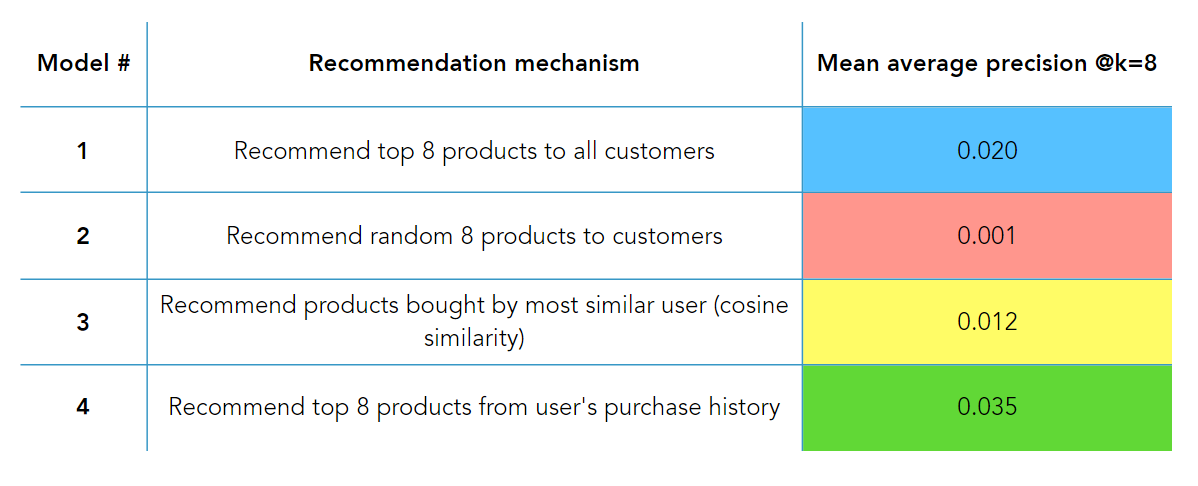

## 5.4.2 Model 5: LightFM model

In [5]:
#The lightFM model needs the size of training and testing to be the same. So, we only train for users in the training set
users_in_both=list(set(user_product_int_scaled.index).intersection(set(test_user_product_interaction_top1000.index)))
train_set=user_product_int_scaled.loc[users_in_both,:]
test_set=test_user_product_interaction_top1000.loc[users_in_both,:]
test_set.columns=products_in_matrix

In [6]:
test_set=coo_matrix(test_set)
train_set=coo_matrix(train_set)

In [7]:
# initialising model with warp loss function
model = LightFM(loss = "warp")

# fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()

model.fit(train_set, user_features=None, item_features=None, 
sample_weight=None, epochs=10, num_threads=4,verbose=False)

end = time.time()
print("time taken = ",round(end - start, 2),"seconds")

time taken =  116.29 seconds


In [8]:
ap = precision_at_k(model = model, 
                        test_interactions = coo_matrix(test_set),
                        num_threads = 4,k=8, check_intersections = False)

#print("time taken = {0:.{1}f} seconds".format(end - start, 2))
print("average MAP = {0:.{1}f}".format(ap.mean(), 4))

average MAP = 0.1085


### The MAP score when recommending products using LightFM is 0.109

### This model is performing 3x better than our simple recommendation models. So, it is time to identify the hyperparameters for this model that maximizes the MAP value.

## 5.4.3 Hyperparameter tuning for LightFM model

In [9]:
# Calculate and return MAPs
def MAP_for_lightfm_model(learning_rate,epoch):
    model = LightFM(loss = "warp",learning_rate=learning_rate)
    model.fit(train_set,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=epoch, 
          num_threads=4,
          verbose=False)
    ap_current = precision_at_k(model = model, 
                        test_interactions = test_set,
                        num_threads = 4,k=8, check_intersections = False)
    return round(ap_current.mean(),4)

In [10]:
#Dataframe to save yperparamters and performance
hyperparameters={'learning_rate':[],'epoch':[],'MAP':[]}

In [11]:
learning_rate=[0.01,0.1,0.2]
epochs=[1,2,4,6,8,10,25]
scores_based_on_l_e=[]
for l in learning_rate:
    for e in epochs:
        start = time.time()
        scores_based_on_l_e.append(MAP_for_lightfm_model(l,e))
        end = time.time()
        time_taken=round(end - start, 2)
        #print("learning rate:",l,"epochs:",e,"MAP value:",scores_based_on_l_e[-1],"time taken:",time_taken)
        hyperparameters["learning_rate"].append(l)
        hyperparameters["epoch"].append(e)
        hyperparameters["MAP"].append(scores_based_on_l_e[-1])

In [12]:
hyperparameters

{'learning_rate': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2,
  0.2],
 'epoch': [1,
  2,
  4,
  6,
  8,
  10,
  25,
  1,
  2,
  4,
  6,
  8,
  10,
  25,
  1,
  2,
  4,
  6,
  8,
  10,
  25],
 'MAP': [0.0893,
  0.0906,
  0.0934,
  0.0952,
  0.0947,
  0.1001,
  0.103,
  0.0967,
  0.1019,
  0.1057,
  0.107,
  0.1075,
  0.1092,
  0.1123,
  0.0893,
  0.0931,
  0.0972,
  0.1003,
  0.1018,
  0.1038,
  0.1091]}

## Hyperparameter selection

Let us plot and find the best value for the hyperparameter

In [13]:
hyperparameters_df=pd.DataFrame(hyperparameters)
hyperparameters_df.head(2)

,learning_rate,epoch,MAP
0,0.01,1,0.0893
1,0.01,2,0.0906


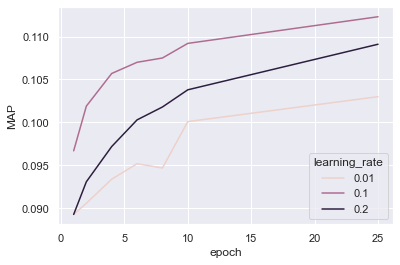

In [15]:
sns.set()
sns.lineplot(data=hyperparameters_df,x="epoch",y=hyperparameters_df["MAP"],hue="learning_rate")
plt.show()

#### Since the learning rate of 0.1 is performing better and the MAP is increasing with the number of epochs, it is trained on 50 epochs and tested to see the difference in performance.

In [16]:
# initialising model with warp loss function
model = LightFM(loss = "warp",learning_rate=0.1)

#fit the model
model.fit(train_set, user_features=None, item_features=None, 
sample_weight=None, epochs=50, num_threads=4,verbose=False)

#calcualte average precision
ap = precision_at_k(model = model, 
                            test_interactions = test_set,
                            num_threads = 4,k=8, check_intersections = False)

#calculate mean average presiosn
map_current=round(ap.mean(),4)

print("The MAP when learning rate=0.1 and epochs=50 is:",map_current)

The MAP when learning rate=0.1 and epochs=50 is: 0.1133


In [20]:
#comparing learning rates at 25 epochs and 50 epochs
print(hyperparameters_df.loc[hyperparameters_df["learning_rate"]==0.1])

    learning_rate  epoch     MAP
7             0.1      1  0.0967
8             0.1      2  0.1019
9             0.1      4  0.1057
10            0.1      6  0.1070
11            0.1      8  0.1075
12            0.1     10  0.1092
13            0.1     25  0.1123


### The value of MAP only increases by 0.5% between 25 and 50 epochs. Alo, from the graph above, it is clear that the impact of epochs on MAP has almost stabilised. 

### So, the model with learning rate of 0.1 and epochs of 50 is chosen as the final model for making recommendations.

## 5.5 Making sample recommendations

In [23]:
#Getting recommendations for user 1 with the final model
scores=model.predict(1, np.arange(len(products_in_matrix)))  # predict for user 1
recommended_items=products_in_matrix.iloc[np.argsort(-scores)][:8]    # arrange in descending order of prob. and select 8
print(recommended_items.values)                                    # display recommended items

['Banana' 'Total 2% with Strawberry Lowfat Greek Strained Yogurt'
 'Total 2% Lowfat Greek Strained Yogurt with Peach'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'
 'Total 0% Raspberry Yogurt'
 'Total 2% All Natural Greek Strained Yogurt with Honey'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'
 'Bag of Organic Bananas']


In [24]:
#Getting recommendations for user 2 with the final model
scores=model.predict(2, np.arange(len(products_in_matrix)))  # predict for user 2
recommended_items=products_in_matrix.iloc[np.argsort(-scores)][:8]    # arrange in descending order of prob. and select 8
print(recommended_items.values)                                    # display recommended items

['Organic Strawberries' 'Organic Baby Spinach' 'Bag of Organic Bananas'
 'Organic Hass Avocado' 'Banana' 'Organic Avocado' 'Limes'
 'Organic Garlic']


## 5.6 Summary

So, based on the user-product interaction, the recommendations can be made to customers to increase revenue and profit. Though MAP is higher for the LightFM model, the model has to be validated online and metrics like Clickthrough Rate, Conversion Rate, Long Term customer value also need to be validated.

For customers without interactions, we could use our naive model of recommending the highest selling products. For new products, the similarity can be calculated among products for recommendation.

## 5.7 Further Work

The models built here does not take into consideration the user's features (metadata) as well as product's features. This can be included to evaluate model performance. Also, historical price of products might help in understanding why a customer bought a product at a certain point of time. A basic recommendation system is built here which can be improved by adding features to the model and changing the other hyperparameters.